In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

In [3]:
# Funzione per generare la tabella
def genera_tabella(valori, colonne, titolo="Tabella", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))  # Aumenta la dimensione per lasciare più spazio al titolo
    else:
        fig = ax.get_figure()

    ax.axis('tight')  # Disabilita gli assi
    ax.axis('off')    # Disabilita gli assi

    # Usa matplotlib per creare la tabella visiva
    table = ax.table(cellText=valori, colLabels=colonne, loc='center', cellLoc='center')

    # Personalizzazione estetica
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Font più piccolo
    table.scale(0.8, 1.5)   # Scala ridotta delle celle (altezza e larghezza)

    # Modifica i bordi delle celle
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Modifica la prima riga (intestazione)
            cell.set_fontsize(12)  # Font dell'intestazione un po' più grande
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#B0C4DE')  # Colore di sfondo per l'intestazione
        else:
            cell.set_edgecolor('gray')  # Colore dei bordi
            cell.set_facecolor('#f9f9f9')  # Colore di sfondo delle celle

    # Aggiungi il titolo sopra la tabella
    ax.set_title(titolo, fontsize=12, weight='bold', pad=10)  # Titolo più piccolo

    return fig, ax


In [4]:
def plot_class_distribution(df, column_name, title='Distribuzione delle Classi', color='navy', ax=None):
    # Impostazioni estetiche per il grafico
    sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

    # Creazione del grafico
    if ax is None:
        ax = plt.gca()  # Se non viene passato un asse, usa quello corrente
    sns.countplot(x=column_name, data=df, color=color, ax=ax)  # Imposta un colore uniforme per le barre

    # Titolo e etichette
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Classi', fontsize=14)
    ax.set_ylabel('Numero di Occorrenze', fontsize=14)

    # Aggiungere il numero sopra ogni barra con lo stesso colore della barra
    for p in ax.patches:
        height = int(p.get_height())  # Otteniamo l'altezza della barra
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, 
                    color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                    xytext=(0, 5), textcoords='offset points')

In [5]:
# Caricamento Dataset
data = pd.read_csv("/Users/diego/Desktop/dataset_ottimizzato.csv")

In [6]:
data.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [7]:
# Separazione delle feature e del target
X = data[['Gene', 'Variation', 'text']]  # Feature
y = data['Class']  # Target

In [8]:
# OneHot Encoding per Gene e Variation
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Adatta e trasforma sul training set
X_gene_variation_encoded = onehot_encoder.fit_transform(X[['Gene', 'Variation']])

In [9]:
# Divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limita il numero di feature
X_train_text_tfidf = tfidf.fit_transform(X_train['text'])  # Solo sul training set
X_test_text_tfidf = tfidf.transform(X_test['text'])        # Usa lo stesso fit sul test set

# SVD
svd = TruncatedSVD(n_components=300, random_state=42)  # Riduci a 300 dimensioni
X_train_text_svd = svd.fit_transform(X_train_text_tfidf)  # Solo sul training set
X_test_text_svd = svd.transform(X_test_text_tfidf)        # Usa lo stesso fit sul test set

#SCALER
scaler = StandardScaler()
X_train_text_scaled = scaler.fit_transform(X_train_text_svd)  # Training set
X_test_text_scaled = scaler.transform(X_test_text_svd)        # Test set


In [11]:
# Concatena le feature (Gene, Variation) con quelle testuali
X_train_gene_variation_encoded = onehot_encoder.transform(X_train[['Gene', 'Variation']])
X_test_gene_variation_encoded = onehot_encoder.transform(X_test[['Gene', 'Variation']])

X_train_final = np.hstack([X_train_gene_variation_encoded, X_train_text_scaled])
X_test_final = np.hstack([X_test_gene_variation_encoded, X_test_text_scaled])

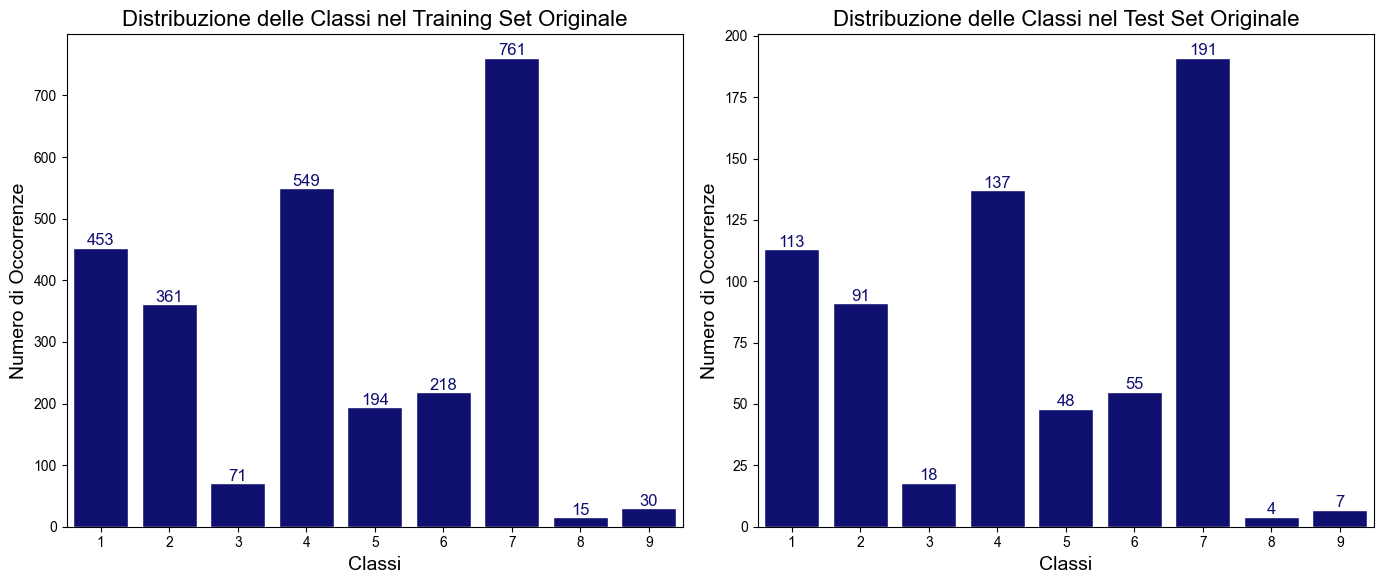

In [12]:
# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il training set
plot_class_distribution(df=pd.DataFrame({'Class': y_train}), column_name='Class', title='Distribuzione delle Classi nel Training Set Originale', color='navy', ax=axes[0])

# Grafico per il test set
plot_class_distribution(df=pd.DataFrame({'Class': y_test}), column_name='Class', title='Distribuzione delle Classi nel Test Set Originale', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

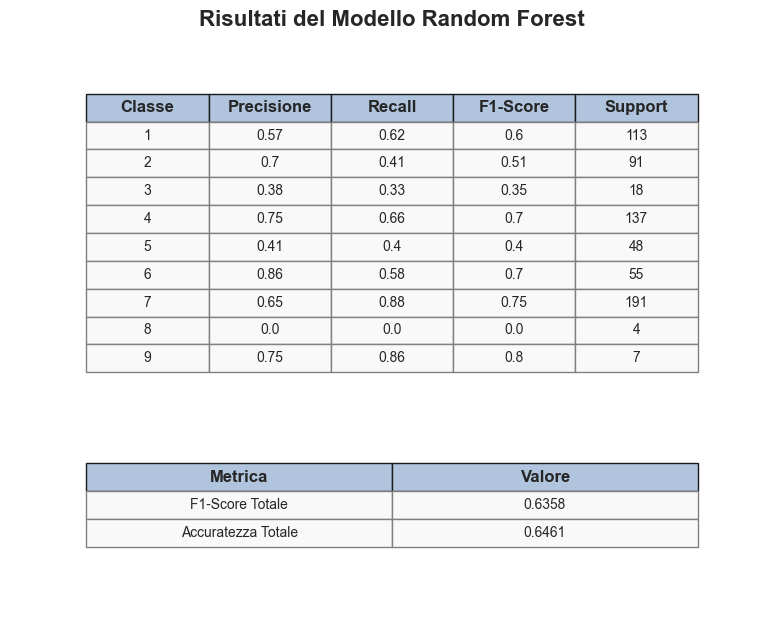

In [13]:
# Definizione dei parametri da ottimizzare
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 20, None],
    'class_weight': [None, 'balanced']
}

# Creazione del modello RandomForest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search con scoring basato sull'F1-score
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_train_final, y_train)

# Miglior modello e parametri
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

# Predizione con il miglior modello
y_pred_rf = best_rf.predict(X_test_final)

# Valutazione del modello
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_df_rf = pd.DataFrame(report_rf).transpose()

# Calcola l'accuratezza totale
accuracy_totale_rf = round(accuracy_score(y_test, y_pred_rf), 4)

# Rimuovi righe non necessarie (macro avg, weighted avg, accuracy)
report_df_rf = report_df_rf.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Arrotonda i valori per migliorare la leggibilità
report_df_rf = report_df_rf.round(2)

# Convertire la colonna 'Support' in valori interi
report_df_rf['support'] = report_df_rf['support'].astype(int)

# Calcolo di F1-Score totale pesato
f1_score_totale_rf = round(f1_score(y_test, y_pred_rf, average='weighted'), 4)

# Preparazione dei dati per la tabella principale
valori_report_rf = report_df_rf.reset_index().values.tolist()
colonne_report_rf = ["Classe", "Precisione", "Recall", "F1-Score", "Support"]

# Preparazione dei dati per la tabella riassuntiva
valori_riassuntivi_rf = [
    ["F1-Score Totale", f1_score_totale_rf],
    ["Accuratezza Totale", accuracy_totale_rf]
]
colonne_riassuntive_rf = ["Metrica", "Valore"]

# Creazione di una griglia di subplot
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Ridotto lo spazio totale per le tabelle

# Aggiungi un titolo unico per il gruppo di tabelle
fig.suptitle("Risultati del Modello Random Forest", fontsize=16, weight='bold', y=1.05)

# Genera la tabella principale (dettagli per classe)
genera_tabella(valori_report_rf, colonne_report_rf, titolo="", ax=axs[0])

# Genera la tabella riassuntiva (F1-score totale e Accuratezza totale)
genera_tabella(valori_riassuntivi_rf, colonne_riassuntive_rf, titolo="", ax=axs[1])

# Ottimizza il layout per ridurre gli spazi inutili
plt.tight_layout()

# Mostra le tabelle
plt.show()


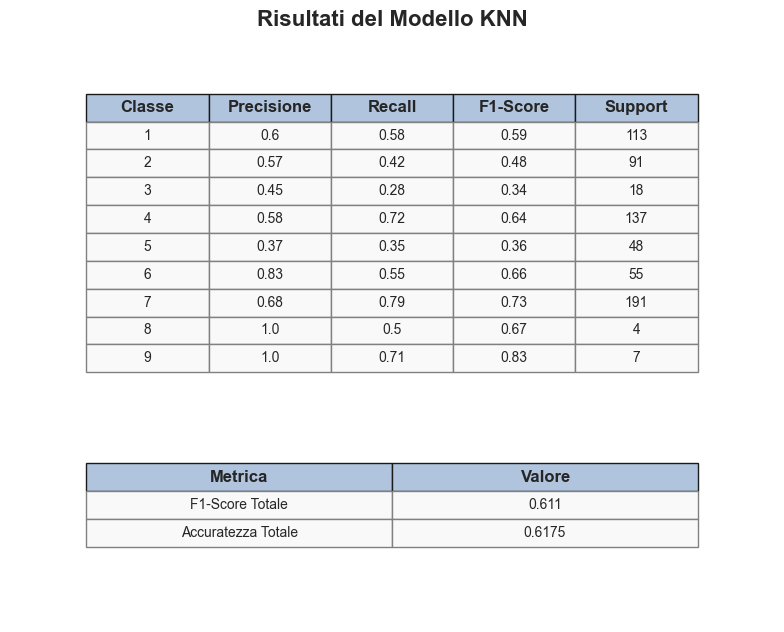

In [14]:
# Definizione dei parametri da ottimizzare
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Creazione del modello KNN
knn = KNeighborsClassifier()

# Grid Search con scoring basato sull'F1-score
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_knn.fit(X_train_final, y_train)

# Miglior modello e parametri
best_knn = grid_search_knn.best_estimator_
best_params_knn = grid_search_knn.best_params_

# Predizione con il miglior modello
y_pred_knn = best_knn.predict(X_test_final)

# Valutazione del modello
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
report_df_knn = pd.DataFrame(report_knn).transpose()

# Calcola l'accuratezza totale
accuracy_totale_knn = round(accuracy_score(y_test, y_pred_knn), 4)

# Rimuovi righe non necessarie (macro avg, weighted avg, accuracy)
report_df_knn = report_df_knn.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Arrotonda i valori per migliorare la leggibilità
report_df_knn = report_df_knn.round(2)

# Convertire la colonna 'Support' in valori interi
report_df_knn['support'] = report_df_knn['support'].astype(int)

# Calcolo di F1-Score totale pesato
f1_score_totale_knn = round(f1_score(y_test, y_pred_knn, average='weighted'), 4)

# Preparazione dei dati per la tabella principale
valori_report_knn = report_df_knn.reset_index().values.tolist()
colonne_report_knn = ["Classe", "Precisione", "Recall", "F1-Score", "Support"]

# Preparazione dei dati per la tabella riassuntiva
valori_riassuntivi_knn = [
    ["F1-Score Totale", f1_score_totale_knn],
    ["Accuratezza Totale", accuracy_totale_knn]
]
colonne_riassuntive_knn = ["Metrica", "Valore"]

# Creazione di una griglia di subplot
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Ridotto lo spazio totale per le tabelle

# Aggiungi un titolo unico per il gruppo di tabelle
fig.suptitle("Risultati del Modello KNN", fontsize=16, weight='bold', y=1.05)

# Genera la tabella principale (dettagli per classe)
genera_tabella(valori_report_knn, colonne_report_knn, titolo="", ax=axs[0])

# Genera la tabella riassuntiva (F1-score totale e Accuratezza totale)
genera_tabella(valori_riassuntivi_knn, colonne_riassuntive_knn, titolo="", ax=axs[1])

# Ottimizza il layout per ridurre gli spazi inutili
plt.tight_layout()

# Mostra le tabelle
plt.show()


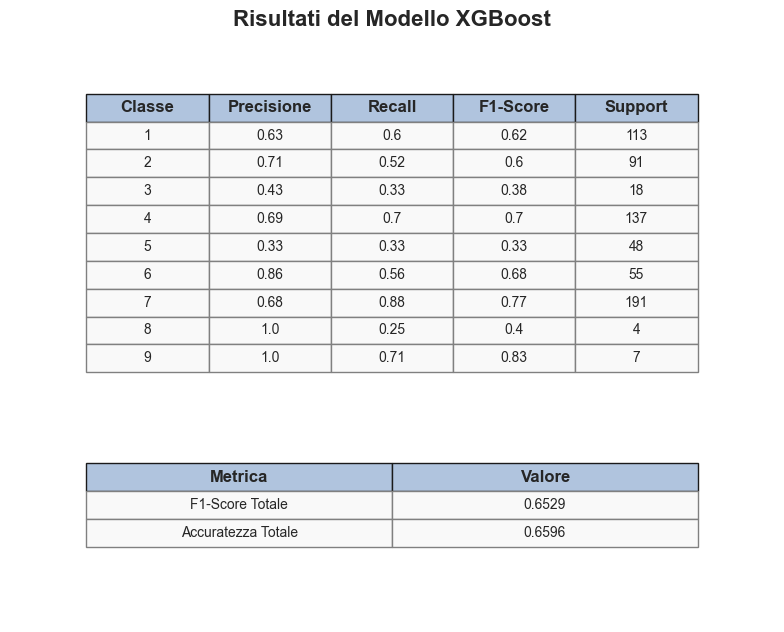

In [17]:
# Encoding delle etichette per XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definizione dei parametri da ottimizzare
param_grid_xgb = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
}

# Creazione del modello XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Grid Search con scoring basato sull'F1-score
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_xgb.fit(X_train_final, y_train_encoded)

# Miglior modello e parametri
best_xgb = grid_search_xgb.best_estimator_

# Predizione con il miglior modello
y_pred_xgb_encoded = best_xgb.predict(X_test_final)

# Decodifica delle etichette per la valutazione
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Valutazione del modello
report_xgb = classification_report(y_test, y_pred_xgb_decoded, output_dict=True)
report_df_xgb = pd.DataFrame(report_xgb).transpose()

# Calcola l'accuratezza totale
accuracy_totale_xgb = round(accuracy_score(y_test, y_pred_xgb_decoded), 4)

# Rimuovi righe non necessarie (macro avg, weighted avg, accuracy)
report_df_xgb = report_df_xgb.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Arrotonda i valori per migliorare la leggibilità
report_df_xgb = report_df_xgb.round(2)

# Convertire la colonna 'Support' in valori interi
report_df_xgb['support'] = report_df_xgb['support'].astype(int)

# Calcolo di F1-Score totale pesato
f1_score_totale_xgb = round(f1_score(y_test, y_pred_xgb_decoded, average='weighted'), 4)

# Preparazione dei dati per la tabella principale
valori_report_xgb = report_df_xgb.reset_index().values.tolist()
colonne_report_xgb = ["Classe", "Precisione", "Recall", "F1-Score", "Support"]

# Preparazione dei dati per la tabella riassuntiva
valori_riassuntivi_xgb = [
    ["F1-Score Totale", f1_score_totale_xgb],
    ["Accuratezza Totale", accuracy_totale_xgb]
]
colonne_riassuntive_xgb = ["Metrica", "Valore"]

# Creazione di una griglia di subplot
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Ridotto lo spazio totale per le tabelle

# Aggiungi un titolo unico per il gruppo di tabelle
fig.suptitle("Risultati del Modello XGBoost", fontsize=16, weight='bold', y=1.05)

# Genera la tabella principale (dettagli per classe)
genera_tabella(valori_report_xgb, colonne_report_xgb, titolo="", ax=axs[0])

# Genera la tabella riassuntiva (F1-score totale e Accuratezza totale)
genera_tabella(valori_riassuntivi_xgb, colonne_riassuntive_xgb, titolo="", ax=axs[1])

# Ottimizza il layout per ridurre gli spazi inutili
plt.tight_layout()

# Mostra le tabelle
plt.show()


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per disegnare la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Dataset Originale - {model_name}")
    plt.xlabel("Classi Predette")
    plt.ylabel("Classi Reali")
    plt.show()

# Classi utilizzate nel dataset (ordinate)
classes = sorted(y_test.unique())



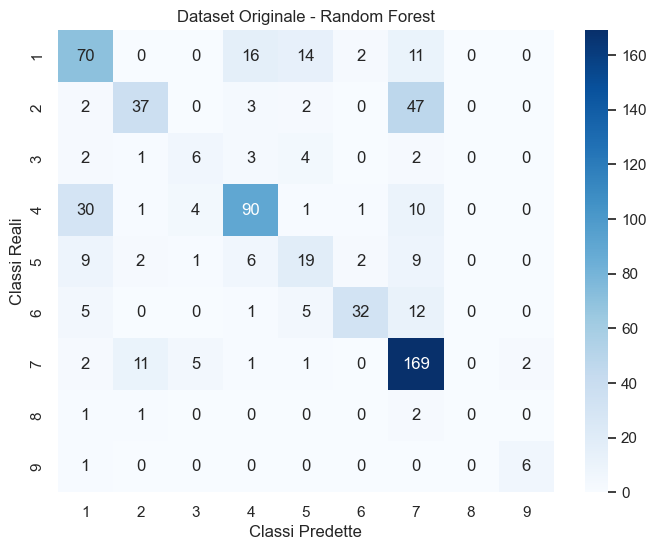

In [29]:
# Matrice di confusione per Random Forest
plot_confusion_matrix(y_test, y_pred_rf, classes, "Random Forest")

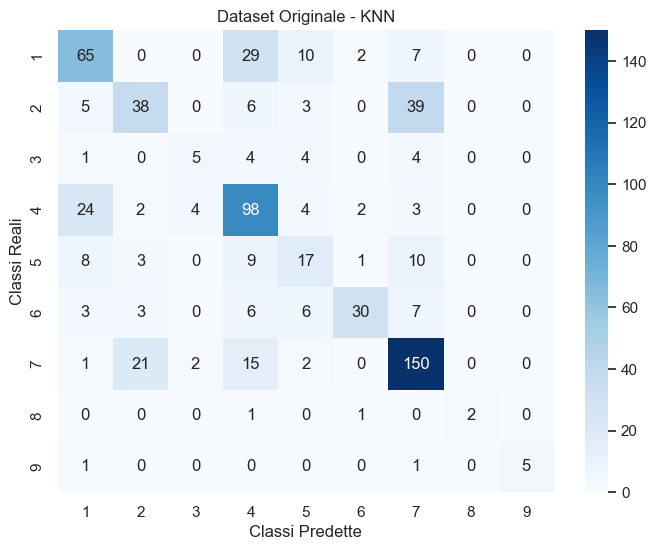

In [30]:
# Matrice di confusione per KNN
plot_confusion_matrix(y_test, y_pred_knn, classes, "KNN")


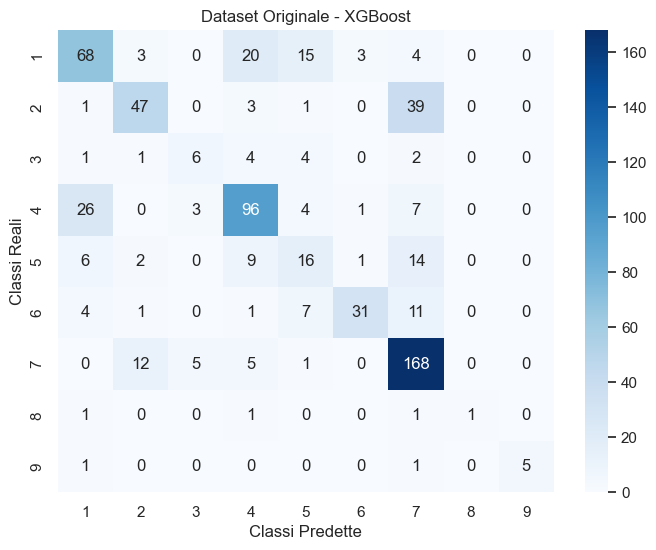

In [31]:
# Matrice di confusione per XGBoost
plot_confusion_matrix(y_test, y_pred_xgb_decoded, classes, "XGBoost")